# ITR Tool - Quick Temperature Score Calculation
This notebook provides a simple example of the ITR Toolkit. It shows how to use it to calculate the temperature score for companies, aggregate them to a portfolio level to get the portfolio temperature score. 


### Getting started
Make sure you are running the notebook with the requirements installed available in the example folder

In [1]:
#If not already installed uncomment line below
#!pip install ITR

In [2]:
import ITR
from ITR.data.excel import ExcelProviderCompany, ExcelProviderProductionBenchmark, ExcelProviderIntensityBenchmark
from ITR.data.data_warehouse import DataWarehouse
from ITR.portfolio_aggregation import PortfolioAggregationMethod
from ITR.temperature_score import TemperatureScore
from ITR.interfaces import ETimeFrames, EScope
import pandas as pd

from ITR.data.osc_units import ureg, Q_, PA_

In [3]:
one_co2 = ureg("CO2e")
print(one_co2)

one_Gt_co2 = ureg("Gt CO2e")
print(one_Gt_co2)

1 CO2e
1 CO2e * gigametric_ton


## Download the dummy data warehouse

We have prepared dummy data for you to be able to run the tool as it is to familiarise yourself with how it works. To use your own data; please check out to the [Data Requirements section](https://os-c.github.io/ITR/DataRequirements.html) of the technical documentation for more details on data requirements and formatting. 

*The dummy data may include some company names, but the data associated with those company names is completely random and any similarities with real world data is purely coincidental. 


In [4]:
import urllib.request
import os

if not os.path.isdir("data"):
    os.mkdir("data")
if not os.path.isfile("data/test_data_company.xlsx"):
    urllib.request.urlretrieve("https://github.com/os-c/ITR/raw/main/examples/data/test_data_company.xlsx", "data/test_data_company.xlsx")
if not os.path.isfile("data/OECM_EI_and_production_benchmarks.xlsx"):
    urllib.request.urlretrieve("https://github.com/os-c/ITR/raw/main/examples/data/OECM_EI_and_production_benchmarks.xlsx", "data/OECM_EI_and_production_benchmarks.xlsx")
if not os.path.isfile("data/example_portfolio.csv"):
    urllib.request.urlretrieve("https://github.com/os-c/ITR/raw/main/examples/data/example_portfolio.csv", "data/example_portfolio.csv")
if not os.path.isfile("utils.py"):
    urllib.request.urlretrieve("https://github.com/os-c/ITR/raw/main/examples/utils.py", "utils.py")
try:  # Import statement when run in remote Jupyter servers from AWS Google etc..
    from utils import collect_company_contributions, plot_grouped_statistics, anonymize, \
        plot_grouped_heatmap, print_grouped_scores, get_contributions_per_group
except:  # Import statement when run locally
    from utils import collect_company_contributions, plot_grouped_statistics, anonymize, \
        plot_grouped_heatmap, print_grouped_scores, get_contributions_per_group

##### Logging
The ITR module uses the Python standard library logging utilities to send log messages. The log level can be changed according to the user's needs.

In [5]:
import logging
root_logger = logging.getLogger()
root_logger.setLevel("INFO")

## Create a data provider
Data providers let you connect to the data source of your choice. In this case we are connecting to Excel as a data provider. 

In [6]:
excel_company_data = ExcelProviderCompany(excel_path="data/test_data_company.xlsx")

In [7]:
excel_production_bm = ExcelProviderProductionBenchmark(excel_path="data/OECM_EI_and_production_benchmarks.xlsx")

In [8]:
excel_EI_bm = ExcelProviderIntensityBenchmark(excel_path="data/OECM_EI_and_production_benchmarks.xlsx",benchmark_temperature=Q_(1.5, ureg.delta_degC),
                                                           benchmark_global_budget=396 * ureg('Gt CO2'), is_AFOLU_included=False)

In [9]:
excel_provider = DataWarehouse(excel_company_data, excel_production_bm, excel_EI_bm)

## Load your portfolio
In our case the portfolio is stored as a CSV file. The portfolio should at least have an "id" (the identifier of the company) and a "proportion" (the weight of the company in your portfolio e.g. the value of the shares you hold) column.

Please see the technical documentation on [Data Legends](https://ofbdabv.github.io/ITR/Legends.html#) for details on data requirements.

In [10]:
df_portfolio = pd.read_csv("data/example_portfolio.csv", encoding="iso-8859-1", sep=';')

In [11]:
df_portfolio.head(5)

,company_name,company_id,company_isin,investment_value
0,Company AG,US0079031078,US0079031078,35000000
1,Company AH,US00724F1012,US00724F1012,10000000
2,Company AI,FR0000125338,FR0000125338,10000000
3,Company AJ,US17275R1023,US17275R1023,10000000
4,Company AK,CH0198251305,CH0198251305,10000000


To load the data from the data provider, we have to pass a list of IPortfolioCompany instances. The module has a strict [data model](https://ofbdabv.github.io/ITR/autoapi/ITR/interfaces/index.html) to convert Pandas Dataframe to the right object types we supplied a utility function.


In [12]:
companies = ITR.utils.dataframe_to_portfolio(df_portfolio)

## Calculate the temperature scores
In the amended portfolio you'll find your original portfolio, amended with the emissions and the temperature score.

In [13]:
temperature_score = TemperatureScore(               
    time_frames = [ETimeFrames.LONG],     
    scopes=[EScope.S1S2],    
    aggregation_method=PortfolioAggregationMethod.WATS # Options for the aggregation method are WATS, TETS, AOTS, MOTS, EOTS, ECOTS, and ROTS.
)
amended_portfolio = temperature_score.calculate(data_warehouse=excel_provider, portfolio=companies)

/opt/app-root/lib64/python3.8/site-packages/pandas/core/dtypes/cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


calculate scopes = [<EScope.S1S2: 'S1+S2'>]


For every company the tool assigns a score for all the requested timeframe and scope combinations. For now the ITR methodolgy only supportt a long timeframe in combination with a S1S2 scope

In [14]:
amended_portfolio[['company_name', 'time_frame', 'scope', 'temperature_score']].head(9)

,company_name,time_frame,scope,temperature_score
0,Company M,LONG,S1S2,1.5 delta_degree_Celsius
1,Company J,LONG,S1S2,1.5 delta_degree_Celsius
2,Company K,LONG,S1S2,1.5 delta_degree_Celsius
3,Company L,LONG,S1S2,1.5 delta_degree_Celsius
4,Company AQ,LONG,S1S2,1.5 delta_degree_Celsius
5,Company AK,LONG,S1S2,1.5 delta_degree_Celsius
6,Company G,LONG,S1S2,1.5 delta_degree_Celsius
7,Company H,LONG,S1S2,1.5 delta_degree_Celsius
8,Company I,LONG,S1S2,1.5 delta_degree_Celsius


## Calculate the aggregated temperature score
Calculate an aggregated temperature score. This can be done using different aggregation methods. Here we'll use the "Weighted Average Temperature Score" (WATS) by initializing the TemperatureScore Object with PortfolioAggregationMethod.WATS. The temperature scores are calculated per time-frame/scope combination.


In [15]:
aggregated_scores = temperature_score.aggregate_scores(amended_portfolio)

/opt/app-root/lib64/python3.8/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)


In [16]:
aggregated_scores.long.S1S2.all.score

1.5000000000000004 <Unit('delta_degree_Celsius')>


The first analysis of your portfolio could be to understand if you have any particular hotspots in your portfolio. We can do that by analysing different groupings of companies.

The tool allows you to calculate temperature scores for _groups_ of companies. In this example we group the scores by sector and region, and leave the timeframe and scope unchanged. Any categorical variable in the data provided by you or your data provider (in the `test_company_data.xlsx` imported above) can be used as grouping variable, e.g. sectors, industries, regions, countries, market cap buckets, as well as the additional fields you imported via the portfolio data.

You can change the variable by which the data is grouped by replacing the fourth line in the following cell. For example, replacing "grouping=['sector', 'region']" by "grouping=['sector', 'country']" would result in temperature scores per sector per country. 
If you want to change the time frame as well, please refer to the section 'Calculate the company temperature scores' above.



In [17]:
grouping = ['sector', 'region']
temperature_score.grouping = grouping
grouped_portfolio = temperature_score.calculate(data_warehouse=excel_provider, portfolio=companies)
grouped_aggregations = temperature_score.aggregate_scores(grouped_portfolio)

/opt/app-root/lib64/python3.8/site-packages/pandas/core/dtypes/cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


calculate scopes = [<EScope.S1S2: 'S1+S2'>]



The aggregated scores can then be used, for example, to show the relation between sectors and regions with respect to temperature score.
A visualization of this relation is shown in the heatmap below. The grey fields indicate that the portfolio contains no assest for those combinations.

##### Quick analysis

We can see here that our Suth American Steelis in reasonable shape. While Asian Steel can be improved as shown in the drill down below the graph



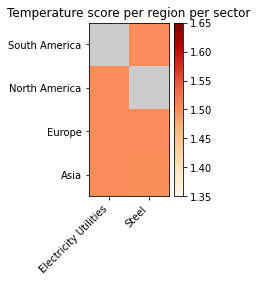

In [18]:
analysis_parameters = ([ETimeFrames.LONG], [EScope.S1S2], grouping)
plot_grouped_heatmap(grouped_aggregations, analysis_parameters)

In [19]:
region =  'Asia'
sector = 'Steel'
group = sector + '-' + region
group_contributions = get_contributions_per_group(grouped_aggregations, analysis_parameters, group)
group_contributions.round(2)

,group,company_name,company_id,temperature_score,contribution_relative
0,Steel-Asia,Company J,BR0000000010,1.5 delta_degree_Celsius,9.090909090909093 delta_degree_Celsius
1,Steel-Asia,Company L,BR0000000012,1.5 delta_degree_Celsius,9.090909090909093 delta_degree_Celsius
2,Steel-Asia,Company G,CN0000000007,1.5 delta_degree_Celsius,9.090909090909093 delta_degree_Celsius
3,Steel-Asia,Company H,CN0000000008,1.5 delta_degree_Celsius,9.090909090909093 delta_degree_Celsius
4,Steel-Asia,Company I,CN0000000009,1.5 delta_degree_Celsius,9.090909090909093 delta_degree_Celsius
5,Steel-Asia,Company C,IT0000000003,1.5 delta_degree_Celsius,9.090909090909093 delta_degree_Celsius
6,Steel-Asia,Company A,JP0000000001,1.5 delta_degree_Celsius,9.090909090909093 delta_degree_Celsius
7,Steel-Asia,Company F,NL0000000006,1.5 delta_degree_Celsius,9.090909090909093 delta_degree_Celsius
8,Steel-Asia,Company D,SE0000000004,1.5 delta_degree_Celsius,9.090909090909093 delta_degree_Celsius
9,Steel-Asia,Company E,SE0000000005,1.5 delta_degree_Celsius,9.090909090909093 delta_degree_Celsius


#### Sector analysis

Sector analysis may help us with bringing some clarity into our analysis from the heatmap above. In order to identify the companies that your portfolio would most benefit from engaging with, we can start with identifying the biggest contributing sectors to the portfolio's temperature score, as in our example below.

Contributions can be identified on an individual company level, as well as contributions from companies grouped by one of their characteristics, e.g. sector or region. The exact definitions of companies' contributions to the portfolio temperature scores depend on the selected aggregation method.

You can group companies on any categorical variable (e.g. sectors, countries, market cap buckets, investment strategies, etc)  you provide through your dataprovider, in this example in the test_company_data.xlsx imported above.

For our analysis we select one time-frame (LONG) and one scope (S1+S2) and group the outcomes on sector and compare AUM to temperature score contribution. We also then display the sector temperature scores.

##### Quick analysis

In this example we can see that both sectors Steel and Electricity are scoring above 2.0C. 


In [20]:
time_frames = [ETimeFrames.LONG]
scopes = [EScope.S1S2]
grouping = ['sector']
analysis_parameters = (time_frames, scopes, grouping)

temperature_score = TemperatureScore(time_frames=time_frames,
                                     scopes=scopes,
                                     grouping=grouping)
amended_portfolio = temperature_score.calculate(data_warehouse=excel_provider, portfolio=companies)
aggregated_portfolio = temperature_score.aggregate_scores(amended_portfolio)
company_contributions = collect_company_contributions(aggregated_portfolio, amended_portfolio, analysis_parameters)

/opt/app-root/lib64/python3.8/site-packages/pandas/core/dtypes/cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


calculate scopes = [<EScope.S1S2: 'S1+S2'>]


/opt/app-root/lib64/python3.8/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)


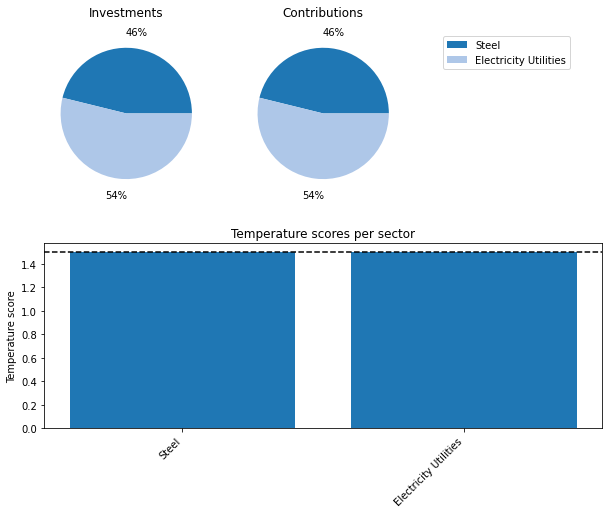

In [21]:
plot_grouped_statistics(aggregated_portfolio, company_contributions, analysis_parameters)

We can use what we learned from this analysis to drill into a few of the highest contributing scoring sectors to see which
companies are the biggest contributors on the sector level. Considering the Steel sector, for instance, in the
table below.


In [22]:
sector_contributions = company_contributions[['company_name', 'company_id', 'sector', 'contribution', 'temperature_score', 'ownership_percentage', 'portfolio_percentage']]
sector_contributions.loc[sector_contributions['sector'] == 'Steel'][:10].round(2)

,company_name,company_id,sector,contribution,temperature_score,ownership_percentage,portfolio_percentage
1,Company M,AR0000000013,Steel,3.076923076923076 delta_degree_Celsius,1.5 delta_degree_Celsius,1.07,3.08
28,Company K,BR0000000011,Steel,3.076923076923076 delta_degree_Celsius,1.5 delta_degree_Celsius,1.01,3.08
27,Company L,BR0000000012,Steel,3.076923076923076 delta_degree_Celsius,1.5 delta_degree_Celsius,0.15,3.08
24,Company G,CN0000000007,Steel,3.076923076923076 delta_degree_Celsius,1.5 delta_degree_Celsius,0.05,3.08
23,Company H,CN0000000008,Steel,3.076923076923076 delta_degree_Celsius,1.5 delta_degree_Celsius,0.18,3.08
22,Company I,CN0000000009,Steel,3.076923076923076 delta_degree_Celsius,1.5 delta_degree_Celsius,0.33,3.08
17,Company C,IT0000000003,Steel,3.076923076923076 delta_degree_Celsius,1.5 delta_degree_Celsius,0.34,3.08
16,Company A,JP0000000001,Steel,3.076923076923076 delta_degree_Celsius,1.5 delta_degree_Celsius,1.07,3.08
14,Company B,NL0000000002,Steel,3.076923076923076 delta_degree_Celsius,1.5 delta_degree_Celsius,1.51,3.08
13,Company F,NL0000000006,Steel,3.076923076923076 delta_degree_Celsius,1.5 delta_degree_Celsius,0.11,3.08


### Save your data for further analysis
To take your analysis outside of this notebook and for example for internal and client reporting, you can export all data to Excel and the clipboard for pasting into and analysing in other applications.

If you run the ITR tool locally or from Google Colab, you:
- Specify the filenames of the output files in the cell below, e.g. change 'data_dump.xlsx' in the first line to 'TS_output.xlsx'
- Run the cell below

In [23]:
data_dump_filename = 'data_dump.xlsx'
amended_portfolio.set_index(['company_name', 'company_id']).to_excel(data_dump_filename)